<center>
    <H1> NAIVE BAYES CLASSIFIER </H1>
    <br>
======================================================================================================================
<br>
Naive Bayes Classification algorithm is a type of supervised machine learning algorithm. It is extremely easy to implement in its most basic form, and yet performs quite complex classification tasks.
We’ll build a simple email classifier using Multinomial Naive Bayes Classifier.

## STEP 1: IMPORTING LIBRARIES

In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import math 
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split  

## STEP 2: LOADING DATASET

Load the required dataset

In [2]:
#mails_dataset = pd.read_csv('Dataset/trial_spam.csv', encoding = 'latin-1')
mails_dataset = pd.read_csv('Dataset/spam.csv', encoding = 'latin-1')
mails_dataset.head()           #show first 5 rows

,sno,v1,v2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38
0,1,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## STEP 3: FEATURE SELECTION

Select the relevant features, important for mail classification. We can see that column Unamed are irrelevant for our classifier. Thus, we need to remove them. 

In [3]:
#drop undesirable columns
#drop_list = ['Unnamed: 3', 'Unnamed: 4','Unnamed: 5','Unnamed: 6']
mails_dataset.drop(mails_dataset.columns.difference(['sno','v1','v2']), axis = 1, inplace = True)

mails_dataset.head()

,sno,v1,v2
0,1,ham,"Go until jurong point, crazy.. Available only ..."
1,2,ham,Ok lar... Joking wif u oni...
2,3,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,4,ham,U dun say so early hor... U c already then say...
4,5,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#Rename the columns, to make it easy to read and manipulate
mails_dataset.rename(columns = {'sno': 'docID', 'v1': 'label', 'v2': 'message'}, inplace = True)
mails_dataset.head()

,docID,label,message
0,1,ham,"Go until jurong point, crazy.. Available only ..."
1,2,ham,Ok lar... Joking wif u oni...
2,3,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,4,ham,U dun say so early hor... U c already then say...
4,5,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
len(mails_dataset)

5572

In [6]:
mails_dataset['label'].value_counts()  #count number of each label

ham     4825
spam     747
Name: label, dtype: int64

In [7]:
total_mails = mails_dataset.shape[0]            #total number on instances in our dataset
total_mails

5572

## STEP 4: DATA PREPROCESSING

We need to clean our data for further processing. Emails may contain a lot of undesirable characters like punctuation marks, stop words, digits, etc which may not be helpful in detecting the spam email

###  A. Convert to lowercase

In [8]:
#convert the data into lower case
mails_dataset['message'] =  mails_dataset['message'].str.lower()
mails_dataset.head()

,docID,label,message
0,1,ham,"go until jurong point, crazy.. available only ..."
1,2,ham,ok lar... joking wif u oni...
2,3,spam,free entry in 2 a wkly comp to win fa cup fina...
3,4,ham,u dun say so early hor... u c already then say...
4,5,ham,"nah i don't think he goes to usf, he lives aro..."


### B. Convert categorical values to numbers



In [9]:
'''
    ham : 0
    spam : 1
    
'''
mails_dataset['label'] = mails_dataset['label'].map({'ham': 0, 'spam': 1})
mails_dataset.head()

,docID,label,message
0,1,0,"go until jurong point, crazy.. available only ..."
1,2,0,ok lar... joking wif u oni...
2,3,1,free entry in 2 a wkly comp to win fa cup fina...
3,4,0,u dun say so early hor... u c already then say...
4,5,0,"nah i don't think he goes to usf, he lives aro..."


### C. Remove digits and punctutations

In [10]:
#remove all digits
mails_dataset['message'] = mails_dataset['message'].str.replace('\d+.\d+', '')
mails_dataset.head()

,docID,label,message
0,1,0,"go until jurong point, crazy.. available only ..."
1,2,0,ok lar... joking wif u oni...
2,3,1,free entry in 2 a wkly comp to win fa cup fina...
3,4,0,u dun say so early hor... u c already then say...
4,5,0,"nah i don't think he goes to usf, he lives aro..."


In [11]:
'''
     ^   :  Not these characters
     \w  :  Word characters
     \s  :  Space characters

    Replace any character that is not a word character or a space character with nothing/blank.
    
'''
mails_dataset['message'] = mails_dataset['message'].str.replace('[^\w\s]', '')
mails_dataset.head()

,docID,label,message
0,1,0,go until jurong point crazy available only in ...
1,2,0,ok lar joking wif u oni
2,3,1,free entry in 2 a wkly comp to win fa cup fina...
3,4,0,u dun say so early hor u c already then say
4,5,0,nah i dont think he goes to usf he lives aroun...


In [12]:
sample_mail = mails_dataset.iloc[0]
sample_mail['message']

'go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'

### D. Convert all the slang words to corresponding formal words

Slang is the popular informal form of a word or group of words.

In [13]:
#create a dictionary of slang words and their corresponding terms

slang_list = {'u': 'you', 'r': 'are', 'd': "the", 'urs' : 'yours', 'wkly' : 'weekly', 'st' : 'such that', 
              'txt': 'text','comp': 'competition', 'prctc' : 'practice', 'dffrnc': 'difference', 'y': 'why', 
              'f9':'fine', 'tkts': 'tickets', 'csh': 'cash', 'phn': 'phone', 'im': 'i am', 'm': 'am', 
              'spcl': 'special', 'fone': 'phone', 'wks' : 'weeks', 'å': 'a', 'n': 'and', 'wat':'what'}


In [14]:
#replace slang with formal word

sample_mail = mails_dataset.iloc[0]
message = sample_mail['message']
print(message)

new_message = ' '.join(slang_list[i] if i in slang_list else i for i in message.split())
new_message

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat


'go until jurong point crazy available only in bugis and great world la e buffet cine there got amore what'

In [15]:
#applying to all rows

def convert_slangs(row):
    message = row['message']
    new_message = ' '.join(slang_list[i] if i in slang_list else i for i in message.split())
    return new_message

mails_dataset['message'] = mails_dataset.apply(convert_slangs, axis=1)
mails_dataset.head()

,docID,label,message
0,1,0,go until jurong point crazy available only in ...
1,2,0,ok lar joking wif you oni
2,3,1,free entry in 2 a weekly competition to win fa...
3,4,0,you dun say so early hor you c already then say
4,5,0,nah i dont think he goes to usf he lives aroun...


### E. Tokenization

In [16]:
#pick every message and convert it into tokens

def identify_tokens(row):
    message = row['message']
    tokens = word_tokenize(message)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

mails_dataset['tokens'] = mails_dataset.apply(identify_tokens, axis=1)
mails_dataset.head()

,docID,label,message,tokens
0,1,0,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,2,0,ok lar joking wif you oni,"[ok, lar, joking, wif, you, oni]"
2,3,1,free entry in 2 a weekly competition to win fa...,"[free, entry, in, a, weekly, competition, to, ..."
3,4,0,you dun say so early hor you c already then say,"[you, dun, say, so, early, hor, you, c, alread..."
4,5,0,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


### F. Stemming / Lemmatization

Both processes reduce the inflectional forms of word into a common base or root. But we are using lemmatization because it takes care of the context, while stemming simply performs crude cutoff...

In [17]:
'''
stemming = PorterStemmer()
sample_mail = mails_dataset.iloc[0]
tokens = sample_mail['tokens']
stemmed_list = [stemming.stem(word) for word in tokens]
stemmed_list
'''

"\nstemming = PorterStemmer()\nsample_mail = mails_dataset.iloc[0]\ntokens = sample_mail['tokens']\nstemmed_list = [stemming.stem(word) for word in tokens]\nstemmed_list\n"

In [18]:
lemmatizer = WordNetLemmatizer() 

sample_mail = mails_dataset.iloc[0]
tokens = sample_mail['tokens']
lemmatize_list = [lemmatizer.lemmatize(word) for word in tokens]
lemmatize_list

['go',
 'until',
 'jurong',
 'point',
 'crazy',
 'available',
 'only',
 'in',
 'bugis',
 'and',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'there',
 'got',
 'amore',
 'what']

In [19]:
def lemmatize_tokens(row):
    tokens = row['tokens']
    lemmatized_list = [lemmatizer.lemmatize(word) for word in tokens]
    return (lemmatized_list)

mails_dataset['tokens'] = mails_dataset.apply(lemmatize_tokens, axis=1)
mails_dataset.head()

,docID,label,message,tokens
0,1,0,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,2,0,ok lar joking wif you oni,"[ok, lar, joking, wif, you, oni]"
2,3,1,free entry in 2 a weekly competition to win fa...,"[free, entry, in, a, weekly, competition, to, ..."
3,4,0,you dun say so early hor you c already then say,"[you, dun, say, so, early, hor, you, c, alread..."
4,5,0,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, go, to, usf, he, lif..."


### G. Remove stopwords

Stopwords are common words that carry less important meaning than keywords. So, we will remove them.

In [20]:
stop_words = set(stopwords.words('english'))
print(stop_words,)

{'above', "don't", 'couldn', 'if', 'most', 'herself', 'does', 'she', 'at', 'before', 'during', 'in', 'do', "you'll", 'from', 'under', "you'd", 'they', 'yourself', 'those', 'himself', 'into', 'have', 'hadn', 'below', "haven't", 'which', 'his', 'hasn', 'should', 'by', 'further', 'are', "won't", "shouldn't", 'mustn', 'an', "wasn't", 'too', 'so', 'only', 'then', 'isn', 'were', 'while', 'our', 'is', 'them', 'just', 'my', 'wouldn', 'all', 'it', 'myself', 'about', 'once', "mustn't", 'don', "it's", 'll', 'weren', 'where', "shan't", 'ma', 'such', 'again', 'ain', 'to', 'out', 'hers', 'the', "that'll", 'wasn', 'doing', 'here', 'he', 'now', 'there', 'nor', 'your', 'him', 'why', 'ours', 'some', 'her', 'over', 'shouldn', 'this', 'am', 'after', "you've", 'their', 'what', "didn't", 'with', 'any', 'needn', 'up', 'against', 'mightn', "aren't", 'as', 'd', 't', 'we', 'themselves', 'other', 'down', 'than', 'for', 'each', 'yours', 'being', 'had', 'when', 'theirs', "she's", 'doesn', 'o', 'not', 'been', 'no',

In [21]:
def remove_stopwords(row):
    tokens = row['tokens']
    filtered_list = [w for w in tokens if not w in stop_words]
    return (filtered_list)

mails_dataset['tokens'] = mails_dataset.apply(remove_stopwords , axis=1)
mails_dataset.head()

,docID,label,message,tokens
0,1,0,go until jurong point crazy available only in ...,"[go, jurong, point, crazy, available, bugis, g..."
1,2,0,ok lar joking wif you oni,"[ok, lar, joking, wif, oni]"
2,3,1,free entry in 2 a weekly competition to win fa...,"[free, entry, weekly, competition, win, fa, cu..."
3,4,0,you dun say so early hor you c already then say,"[dun, say, early, hor, c, already, say]"
4,5,0,nah i dont think he goes to usf he lives aroun...,"[nah, dont, think, go, usf, life, around, though]"


## >>>> Now our data is cleaned and ready for training <<<<

## STEP 5: CREATING TEST AND TRAIN SETS

We will randomly split our dataset in 80–20 ratio. Where 80% of the total data will be used as training set and rest 20% will be considered as test set. 

In [22]:
#before splitting. Let's, create vocabulary

all_tokens = []

for row in range(total_mails):
        #pick every token list from each row and append to the all tokens list
        tokens = mails_dataset.tokens.iloc[row]
        #append the list to the final list 
        all_tokens += tokens 
    
vocab = np.unique(all_tokens)      #vocabulary is the collection of all terms in the corpus

print("Total number of tokens in the corpus : ", len(all_tokens))
print("Total terms : ", len(vocab))

Total number of tokens in the corpus :  46065
Total terms :  7552


In [23]:
X = mails_dataset.drop('label',axis=1) 
y = mails_dataset['label']

#random state = 0, will give same split evry time. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
test_size, train_size = X_test.shape[0], X_train.shape[0]
print("Number of instance in :\n Training set = ", train_size, "\n Test set = ", test_size)

Number of instance in :
 Training set =  4457 
 Test set =  1115


In [25]:
X_train.head()

,docID,message,tokens
1114,1115,no nothis is kallis home groundamla home town ...,"[nothis, kallis, home, groundamla, home, town,..."
3589,3590,i am in escape theatre now going to watch kava...,"[escape, theatre, going, watch, kavalan, minute]"
3095,3096,we walked from my moms right on stagwood pass ...,"[walked, mom, right, stagwood, pas, right, win..."
1012,1013,i dunno they close oredi not ìï v ma fan,"[dunno, close, oredi, ìï, v, fan]"
3320,3321,yo i am right by yo work,"[yo, right, yo, work]"


In [26]:
#y_train is an array. so in order to concat it with our X variables, we need to convert it into dataframe

labels_train = pd.DataFrame(y_train, columns = ['label'])
labels_train.head()

,label
1114,0
3589,0
3095,0
1012,0
3320,0


In [27]:
'''
    We have X_train, y_train, X_test, y_test.
    Using these lists and dataframes we will randomly create two non-overlapping datasets 
        1. training set
        2. testing set
'''

#creating training set
train_set = pd.concat([X_train, labels_train], axis = 1).reset_index(drop=True)
train_set.head()

,docID,message,tokens,label
0,1115,no nothis is kallis home groundamla home town ...,"[nothis, kallis, home, groundamla, home, town,...",0
1,3590,i am in escape theatre now going to watch kava...,"[escape, theatre, going, watch, kavalan, minute]",0
2,3096,we walked from my moms right on stagwood pass ...,"[walked, mom, right, stagwood, pas, right, win...",0
3,1013,i dunno they close oredi not ìï v ma fan,"[dunno, close, oredi, ìï, v, fan]",0
4,3321,yo i am right by yo work,"[yo, right, yo, work]",0


In [28]:
# Our training set is ready, similarly creating test set

labels_test = pd.DataFrame(y_test, columns = ['label'])
test_set = pd.concat([X_test, labels_test], axis = 1).reset_index(drop=True)
test_set.head()

,docID,message,tokens,label
0,4457,aight should i just plan to come up later tonight,"[aight, plan, come, later, tonight]",0
1,691,was the farm open,"[wa, farm, open]",0
2,945,i sent my scores to sophas and i had to do sec...,"[sent, score, sophas, secondary, application, ...",0
3,3769,was gr8 to see that message so when are you le...,"[wa, see, message, leaving, congrats, dear, sc...",0
4,1190,in that case i guess ill see you at campus lodge,"[case, guess, ill, see, campus, lodge]",0


Our dataset is divided into two parts : train_set and test_set. Now we need to train our model

## STEP 6: TRAINING CLASSIFIER 

## <center>  Multinomial Naive Bayes Classifier

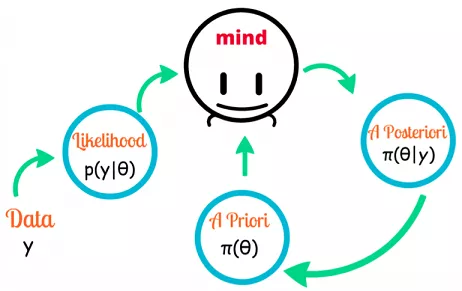

### A . Compute prior probability of each class

Prior probaility of class c, is computed as:

   <center><b> P(c) = (examples with label c) / (total examples)
    

In [29]:
total_classes = train_set['label'].nunique()
total_classes      # total number of classes

2

In [30]:
# create set of all instances wth class label = 1
y1 = train_set[train_set.label == 1]

#instances with class label = 1 
y1.head()

,docID,message,tokens,label
9,2261,splashmobile choose from s of gr8 tones each w...,"[splashmobile, choose, tone, wk, subscrition, ...",1
17,2770,burger king wanna play footy at a top stadium ...,"[burger, king, wan, na, play, footy, top, stad...",1
19,5070,5p 4 alfie moons children in need song on ur m...,"[alfie, moon, child, need, song, ur, mob, tell...",1
27,471,okmail dear dave this is your final notice to ...,"[okmail, dear, dave, final, notice, collect, t...",1
32,2829,send a logo 2 ur lover 2 names joined by a hea...,"[send, logo, ur, lover, name, joined, heart, t...",1


In [31]:
#now calculate the prior probaility of each label/class

prior_prob = {}          #empty array
class_set = {}           #divide the instances into classes

#create set of examples with same class labels and then compute prior prob of each class

for ci in range(total_classes):
    class_set[ci] = train_set[train_set.label == ci]     
    count_label = len(class_set[ci])
    prior_prob[ci] = count_label/train_size       
    
prior_prob    

{0: 0.8696432577967242, 1: 0.13035674220327576}

### B. Creating Bag of Words for each class

Create a BOW model and count number of times each term occurs in each class.

In [32]:
from collections import Counter
z = ['blue', 'red', 'blue', 'yellow', 'blue', 'red']
Counter(z)

Counter({'blue': 3, 'red': 2, 'yellow': 1})

In [33]:
#create bow for each class
bow_class = {}        #set to store bow of each class

#for every class ci
for ci in range(total_classes):
    tokens_class = []            #create empty list of tokens in class ci
    for row in range(len(class_set[ci])):
        #pick tokens from each row and append to the row tokens list
        tokens = class_set[ci].tokens.iloc[row]
        #append the list to the final list 
        tokens_class.extend(tokens) 
    
    bow_class[ci] = tokens_class      # bow of class ci

#bow_class[0]

In [34]:
# calculate the number of occurrences of each term in each class 
# Counter returns a dictionary where key is the term and value is the no of time it occurs 

freq_terms_class = {}

for ci in range(total_classes):
    freq_terms_class[ci] = dict(Counter(bow_class[ci]))

freq_terms_class[0]  

{'nothis': 1,
 'kallis': 4,
 'home': 123,
 'groundamla': 1,
 'town': 23,
 'durban': 2,
 'escape': 4,
 'theatre': 4,
 'going': 133,
 'watch': 29,
 'kavalan': 2,
 'minute': 24,
 'walked': 3,
 'mom': 16,
 'right': 68,
 'stagwood': 1,
 'pas': 7,
 'winterstone': 1,
 'left': 27,
 'victor': 1,
 'hill': 4,
 'address': 12,
 'lt': 122,
 'dunno': 27,
 'close': 14,
 'oredi': 13,
 'ìï': 37,
 'v': 35,
 'fan': 2,
 'yo': 32,
 'work': 78,
 'ur': 187,
 'luck': 6,
 'love': 154,
 'someone': 36,
 'fortune': 1,
 'one': 130,
 'also': 49,
 'know': 190,
 'lunch': 40,
 'menu': 6,
 'da': 108,
 'oh': 84,
 'yeah': 65,
 'diet': 4,
 'flew': 1,
 'window': 3,
 'nah': 7,
 'straight': 3,
 'bring': 22,
 'bud': 4,
 'drink': 15,
 'something': 51,
 'thats': 70,
 'actually': 25,
 'little': 17,
 'useful': 2,
 'cash': 9,
 'fighting': 5,
 'world': 26,
 'easy': 14,
 'either': 12,
 'win': 14,
 'lose': 18,
 'bt': 11,
 'fightng': 3,
 'dificult': 3,
 'still': 117,
 'co': 64,
 'lar': 34,
 'ba': 1,
 'dao': 1,
 'ok': 229,
 'pm': 12,
 '

In [35]:
freq_terms_class[0]['yeah']  #check frequncy of term 'yeah' in class 0

65

### C. Compute Conditional Probability of each term given class

Cond probability of term t given class c, is computed as:

<b><center>P(t|c) = {(Frequency of term t in class c) + 1} / {( Sum of frequencies of each term in class c) + |V|} </b>

where |V| = size of the vocabulary

In [36]:
import copy
#Python never implicitly copies objects. dict2 = dict1, both refer to the same object, 
#so when we mutate dic2, all references to it keep referring to the object in its current state and change dict1 as well

cond_prob_class = {}

for ci in range(total_classes):
    #cond_prob_class[ci] = freq_terms_class[ci]
    cond_prob_class[ci] = freq_terms_class[ci].copy()
    
cond_prob_class[0]   

{'nothis': 1,
 'kallis': 4,
 'home': 123,
 'groundamla': 1,
 'town': 23,
 'durban': 2,
 'escape': 4,
 'theatre': 4,
 'going': 133,
 'watch': 29,
 'kavalan': 2,
 'minute': 24,
 'walked': 3,
 'mom': 16,
 'right': 68,
 'stagwood': 1,
 'pas': 7,
 'winterstone': 1,
 'left': 27,
 'victor': 1,
 'hill': 4,
 'address': 12,
 'lt': 122,
 'dunno': 27,
 'close': 14,
 'oredi': 13,
 'ìï': 37,
 'v': 35,
 'fan': 2,
 'yo': 32,
 'work': 78,
 'ur': 187,
 'luck': 6,
 'love': 154,
 'someone': 36,
 'fortune': 1,
 'one': 130,
 'also': 49,
 'know': 190,
 'lunch': 40,
 'menu': 6,
 'da': 108,
 'oh': 84,
 'yeah': 65,
 'diet': 4,
 'flew': 1,
 'window': 3,
 'nah': 7,
 'straight': 3,
 'bring': 22,
 'bud': 4,
 'drink': 15,
 'something': 51,
 'thats': 70,
 'actually': 25,
 'little': 17,
 'useful': 2,
 'cash': 9,
 'fighting': 5,
 'world': 26,
 'easy': 14,
 'either': 12,
 'win': 14,
 'lose': 18,
 'bt': 11,
 'fightng': 3,
 'dificult': 3,
 'still': 117,
 'co': 64,
 'lar': 34,
 'ba': 1,
 'dao': 1,
 'ok': 229,
 'pm': 12,
 '

In [37]:
len(vocab)

7552

In [38]:
#denominator remains same for all the terms in same class. 
#denom for class 0

denom = sum(freq_terms_class[0].values())+len(vocab)
denom

36502

In [39]:
# for each term in the class, calculate cond prob. this is to be done for all the classes.

#iterate through each class one by one
for ci in range(total_classes):
    # compute cond_prob for each term in this class
    denom = sum(freq_terms_class[ci].values())+len(vocab)
    
    # go to each term in this class and compute its cond_prob within this class
    for term in cond_prob_class[ci]:
        freq_term = freq_terms_class[ci][term]
        cond_prob_class[ci][term] = (freq_term+1)/denom

cond_prob_class[0]   #check cond prob for for each term, given class 0

{'nothis': 5.4791518272971344e-05,
 'kallis': 0.00013697879568242837,
 'home': 0.003397074132924223,
 'groundamla': 5.4791518272971344e-05,
 'town': 0.0006574982192756561,
 'durban': 8.218727740945701e-05,
 'escape': 0.00013697879568242837,
 'theatre': 0.00013697879568242837,
 'going': 0.00367103172428908,
 'watch': 0.0008218727740945702,
 'kavalan': 8.218727740945701e-05,
 'minute': 0.0006848939784121418,
 'walked': 0.00010958303654594269,
 'mom': 0.0004657279053202564,
 'right': 0.0018903073804175114,
 'stagwood': 5.4791518272971344e-05,
 'pas': 0.00021916607309188538,
 'winterstone': 5.4791518272971344e-05,
 'left': 0.0007670812558215988,
 'victor': 5.4791518272971344e-05,
 'hill': 0.00013697879568242837,
 'address': 0.00035614486877431374,
 'lt': 0.003369678373787738,
 'dunno': 0.0007670812558215988,
 'close': 0.0004109363870472851,
 'oredi': 0.0003835406279107994,
 'ìï': 0.0010410388471864555,
 'v': 0.0009862473289134841,
 'fan': 8.218727740945701e-05,
 'yo': 0.0009040600515040272

In [40]:
cond_prob_class[0]['yeah']   

0.0018081201030080544

In [41]:
freq_terms_class[0]['yeah']   

65

Training part is done. We are ready with:

    - vocabulary
    - class prior probability of each class
    - cond prob for each term
    

## STEP 7: TESTING CLASSIFIER 

Now our model is ready. We will test our data against given labels.
For every test case, calculate class score (using Bayes theorem) and assign the class to the test case, having maximum score.

In [42]:
test_set.head()

,docID,message,tokens,label
0,4457,aight should i just plan to come up later tonight,"[aight, plan, come, later, tonight]",0
1,691,was the farm open,"[wa, farm, open]",0
2,945,i sent my scores to sophas and i had to do sec...,"[sent, score, sophas, secondary, application, ...",0
3,3769,was gr8 to see that message so when are you le...,"[wa, see, message, leaving, congrats, dear, sc...",0
4,1190,in that case i guess ill see you at campus lodge,"[case, guess, ill, see, campus, lodge]",0


In [43]:
#given a list of tokens of a test doc, predict best suitable class label

def predictClass(token_list):
    class_score = []
    
    #compute posterior prob of each class
    for ci in range(total_classes):
        score = prior_prob[ci]
        
        for token in token_list:
            if token in cond_prob_class[ci]:
                #print(cond_prob_class[0][token])
                score += math.log(cond_prob_class[ci][token])
            else:
                #print("inside else")
                score += math.log(1/(len(vocab)+sum(freq_terms_class[ci].values())))
                
        class_score.append(score)
        
    return np.argmax(class_score)    #return class label with maximum score

In [44]:
#predict for a test example

example = test_set.tokens.iloc[35]
cls = predictClass(example)
cls

0

In [45]:
test_set.label.iloc[35]   #actual label of the test example

0

In [46]:
'''
    Determine posterior probability of each test example against all classes and predict the 
    label against which the class probability is maximum

'''       
       
predictions = []                       #to store prediction of each test example\

for test_case in range(test_size): 
    
    token_list = test_set.tokens.iloc[test_case]
    
    #predict the class label for each example and append to the predictions list
    predictions.append(predictClass(token_list))

#predictions

<b> Testing is over ! </b>
<br>We have predicted labels for each sample in the test_set.

## STEP 8: ACCURACY OF THE CLASSIFIER

Accuracy is the fraction of correct predictions our model out of total predictions. 
Formally, accuracy has the following definition:
<br><br>
<center><b> Accuracy = (Number of correct predictions) / (Number of total predictions) 


In [47]:
#calculate accuracy
predict_labels = np.array(predictions)
actual_labels = np.array(test_set.label)

test_accuracy = np.sum(predict_labels == actual_labels)/float(test_size) 

print ("******* Test Set Examples ******* : ", test_size)
print ("******* Test Set Accuracy ******* : ", (test_accuracy*100) ,"%") 

******* Test Set Examples ******* :  1115
******* Test Set Accuracy ******* :  95.15695067264573 %
